In [1]:
# 8.3.3 조기종료

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms, datasets

import matplotlib
import matplotlib.pyplot as plt
import time
import argparse
from tqdm import tqdm
matplotlib.style.use('ggplot')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [4]:
train_dataset = datasets.ImageFolder(
    root=r'../chap08/data/archive/train',
    transform=train_transform
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True,
)
val_dataset = datasets.ImageFolder(
    root=r'../chap08/data/archive/test',
    transform=val_transform
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=False,
)

In [5]:
def resnet50(pretrained=True):
    model = models.resnet50(progress=True, pretrained=pretrained)
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    model.fc = nn.Linear(2048, 2)
    return model

In [6]:
class LRScheduler():
    def __init__(
        self, optimizer, patience=5, min_lr=1e-6, factor=0.5
    ):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor
        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( 
                self.optimizer,
                mode='min',
                patience=self.patience,
                factor=self.factor,
                min_lr=self.min_lr,
                verbose=True
            )
    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

In [7]:
class EarlyStopping():
    def __init__(self, patience=5, verbose=False, delta=0, path='../chap08/data/checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [42]:
parser = argparse.ArgumentParser()
parser.add_argument('--lr-scheduler', dest='lr_scheduler', action='store_true')
parser.add_argument('--early-stopping', dest='early_stopping', action='store_true')
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1") #주피터 노트북에서 실행할때 필요합니다
args = vars(parser.parse_args(args=[])) #쥬피터에서 실행가능

In [43]:
#!pip install ipywidgets 혹은
#anaconda prompt에서 conda install -c conda-forge ipywidgets 실행
print(f"Computation device: {device}\n")
model = models.resnet50(pretrained=True).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

Computation device: cpu



c:\Users\LEE\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\LEE\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


25,557,032 total parameters.
25,557,032 training parameters.


In [44]:
lr = 0.001
epochs = 100
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [45]:
loss_plot_name = 'loss'
acc_plot_name = 'accuracy'
model_name = 'model'

In [46]:
if args['lr_scheduler']:
    print('INFO: Initializing learning rate scheduler')
    lr_scheduler = LRScheduler(optimizer)
    loss_plot_name = 'lrs_loss'
    acc_plot_name = 'lrs_accuracy'
    model_name = 'lrs_model'
if args['early_stopping']:
    print('INFO: Initializing early stopping')
    early_stopping = EarlyStopping()
    loss_plot_name = 'es_loss'
    acc_plot_name = 'es_accuracy'
    model_name = 'es_model'

In [47]:
def training(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    for i, data in prog_bar:
        counter += 1
        data, target = data[0].to(device), data[1].to(device)
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [48]:
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0].to(device), data[1].to(device)
            total += target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [49]:
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = training(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_dataloader, val_dataset, criterion
    )
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if args['lr_scheduler']:
        lr_scheduler(val_epoch_loss)
    if args['early_stopping']:
        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            break
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch 1 of 100
Training


  0%|          | 0/15 [00:00<?, ?it/s]

16it [02:17,  8.59s/it]                        


Validating


16it [00:50,  3.15s/it]                        


Train Loss: 2.4028, Train Acc: 56.22
Val Loss: 5.4240, Val Acc: 39.60
Epoch 2 of 100
Training


16it [02:12,  8.29s/it]                        


Validating


16it [00:46,  2.94s/it]                        


Train Loss: 0.5611, Train Acc: 70.48
Val Loss: 0.7488, Val Acc: 65.40
Epoch 3 of 100
Training


16it [02:11,  8.24s/it]                        


Validating


16it [00:46,  2.93s/it]                        


Train Loss: 0.4803, Train Acc: 76.51
Val Loss: 0.5622, Val Acc: 78.00
Epoch 4 of 100
Training


16it [02:11,  8.25s/it]                        


Validating


16it [00:46,  2.93s/it]                        


Train Loss: 0.3808, Train Acc: 83.33
Val Loss: 0.7485, Val Acc: 67.40
Epoch 5 of 100
Training


16it [02:11,  8.24s/it]                        


Validating


16it [00:46,  2.92s/it]                        


Train Loss: 0.3603, Train Acc: 84.94
Val Loss: 0.5126, Val Acc: 78.20
Epoch 6 of 100
Training


16it [02:11,  8.24s/it]                        


Validating


16it [00:46,  2.92s/it]                        


Train Loss: 0.3280, Train Acc: 84.54
Val Loss: 0.6533, Val Acc: 70.80
Epoch 7 of 100
Training


16it [02:12,  8.26s/it]                        


Validating


16it [00:46,  2.93s/it]                        


Train Loss: 0.3350, Train Acc: 85.74
Val Loss: 0.9398, Val Acc: 67.20
Epoch 8 of 100
Training


16it [02:12,  8.25s/it]                        


Validating


16it [00:46,  2.94s/it]                        


Train Loss: 0.2780, Train Acc: 87.95
Val Loss: 1.0541, Val Acc: 68.20
Epoch 9 of 100
Training


16it [02:13,  8.32s/it]                        


Validating


16it [00:46,  2.92s/it]                        


Train Loss: 0.2145, Train Acc: 90.56
Val Loss: 0.7799, Val Acc: 71.20
Epoch 10 of 100
Training


16it [02:12,  8.27s/it]                        


Validating


16it [00:46,  2.91s/it]                        


Train Loss: 0.2234, Train Acc: 90.96
Val Loss: 0.5967, Val Acc: 76.60
Epoch 11 of 100
Training


16it [02:12,  8.27s/it]                        


Validating


16it [00:46,  2.92s/it]                        


Train Loss: 0.2231, Train Acc: 91.77
Val Loss: 0.9881, Val Acc: 70.20
Epoch 12 of 100
Training


16it [02:12,  8.28s/it]                        


Validating


16it [00:51,  3.24s/it]                        


Train Loss: 0.2246, Train Acc: 91.77
Val Loss: 0.6183, Val Acc: 78.00
Epoch 13 of 100
Training


16it [02:14,  8.39s/it]                        


Validating


16it [00:47,  2.95s/it]                        


Train Loss: 0.1506, Train Acc: 92.37
Val Loss: 0.6857, Val Acc: 77.80
Epoch 14 of 100
Training


16it [02:18,  8.67s/it]                        


Validating


16it [00:47,  2.95s/it]                        


Train Loss: 0.2316, Train Acc: 91.77
Val Loss: 0.9928, Val Acc: 71.60
Epoch 15 of 100
Training


16it [02:23,  8.95s/it]                        


Validating


16it [00:50,  3.17s/it]                        


Train Loss: 0.1840, Train Acc: 93.57
Val Loss: 0.8546, Val Acc: 73.20
Epoch 16 of 100
Training


16it [02:39,  9.94s/it]                        


Validating


16it [00:55,  3.50s/it]                        


Train Loss: 0.2425, Train Acc: 91.57
Val Loss: 1.0300, Val Acc: 73.40
Epoch 17 of 100
Training


16it [02:47, 10.50s/it]                        


Validating


16it [01:00,  3.75s/it]                        


Train Loss: 0.1803, Train Acc: 92.77
Val Loss: 1.0519, Val Acc: 71.20
Epoch 18 of 100
Training


16it [02:54, 10.89s/it]                        


Validating


16it [01:02,  3.88s/it]                        


Train Loss: 0.2070, Train Acc: 90.36
Val Loss: 0.6006, Val Acc: 78.00
Epoch 19 of 100
Training


16it [03:04, 11.51s/it]                        


Validating


16it [01:05,  4.11s/it]                        


Train Loss: 0.1608, Train Acc: 93.78
Val Loss: 0.5336, Val Acc: 79.80
Epoch 20 of 100
Training


16it [02:59, 11.24s/it]                        


Validating


16it [00:48,  3.02s/it]                        


Train Loss: 0.1806, Train Acc: 93.17
Val Loss: 0.9093, Val Acc: 72.20
Epoch 21 of 100
Training


16it [02:20,  8.79s/it]                        


Validating


16it [00:55,  3.45s/it]                        


Train Loss: 0.1631, Train Acc: 93.37
Val Loss: 1.1194, Val Acc: 70.00
Epoch 22 of 100
Training


16it [02:31,  9.46s/it]                        


Validating


16it [00:58,  3.65s/it]                        


Train Loss: 0.1160, Train Acc: 95.58
Val Loss: 1.0383, Val Acc: 77.20
Epoch 23 of 100
Training


16it [02:19,  8.70s/it]                        


Validating


16it [00:47,  2.95s/it]                        


Train Loss: 0.1614, Train Acc: 93.37
Val Loss: 0.8425, Val Acc: 74.80
Epoch 24 of 100
Training


16it [02:14,  8.38s/it]                        


Validating


16it [00:48,  3.02s/it]                        


Train Loss: 0.1804, Train Acc: 93.57
Val Loss: 1.1003, Val Acc: 73.40
Epoch 25 of 100
Training


16it [02:19,  8.71s/it]                        


Validating


16it [00:50,  3.15s/it]                        


Train Loss: 0.1081, Train Acc: 97.19
Val Loss: 0.6284, Val Acc: 78.80
Epoch 26 of 100
Training


16it [02:21,  8.87s/it]                        


Validating


16it [00:49,  3.11s/it]                        


Train Loss: 0.0841, Train Acc: 97.19
Val Loss: 0.8421, Val Acc: 74.80
Epoch 27 of 100
Training


16it [02:20,  8.79s/it]                        


Validating


16it [00:47,  3.00s/it]                        


Train Loss: 0.0790, Train Acc: 96.59
Val Loss: 1.0524, Val Acc: 76.00
Epoch 28 of 100
Training


16it [02:14,  8.41s/it]                        


Validating


16it [00:47,  2.97s/it]                        


Train Loss: 0.1040, Train Acc: 96.59
Val Loss: 1.3415, Val Acc: 72.00
Epoch 29 of 100
Training


16it [02:15,  8.49s/it]                        


Validating


16it [00:47,  2.98s/it]                        


Train Loss: 0.0954, Train Acc: 96.18
Val Loss: 1.0629, Val Acc: 75.80
Epoch 30 of 100
Training


16it [02:16,  8.53s/it]                        


Validating


16it [00:47,  3.00s/it]                        


Train Loss: 0.1065, Train Acc: 96.18
Val Loss: 0.6950, Val Acc: 80.20
Epoch 31 of 100
Training


16it [02:16,  8.53s/it]                        


Validating


16it [00:48,  3.05s/it]                        


Train Loss: 0.0859, Train Acc: 97.59
Val Loss: 0.8907, Val Acc: 76.60
Epoch 32 of 100
Training


16it [02:18,  8.67s/it]                        


Validating


16it [00:48,  3.01s/it]                        


Train Loss: 0.0712, Train Acc: 97.19
Val Loss: 1.0252, Val Acc: 74.80
Epoch 33 of 100
Training


16it [02:16,  8.55s/it]                        


Validating


16it [00:48,  3.04s/it]                        


Train Loss: 0.0699, Train Acc: 97.39
Val Loss: 0.8294, Val Acc: 76.80
Epoch 34 of 100
Training


16it [02:17,  8.58s/it]                        


Validating


16it [00:48,  3.02s/it]                        


Train Loss: 0.0918, Train Acc: 96.79
Val Loss: 1.1236, Val Acc: 71.80
Epoch 35 of 100
Training


16it [02:16,  8.55s/it]                        


Validating


16it [00:48,  3.03s/it]                        


Train Loss: 0.0902, Train Acc: 96.99
Val Loss: 0.9164, Val Acc: 76.60
Epoch 36 of 100
Training


16it [02:16,  8.55s/it]                        


Validating


16it [00:48,  3.02s/it]                        


Train Loss: 0.0815, Train Acc: 96.59
Val Loss: 1.0060, Val Acc: 74.20
Epoch 37 of 100
Training


16it [02:17,  8.58s/it]                        


Validating


16it [00:48,  3.03s/it]                        


Train Loss: 0.1292, Train Acc: 95.38
Val Loss: 0.7880, Val Acc: 82.20
Epoch 38 of 100
Training


16it [02:18,  8.63s/it]                        


Validating


16it [00:48,  3.03s/it]                        


Train Loss: 0.0995, Train Acc: 96.39
Val Loss: 0.9925, Val Acc: 74.80
Epoch 39 of 100
Training


16it [02:17,  8.57s/it]                        


Validating


16it [00:48,  3.03s/it]                        


Train Loss: 0.1704, Train Acc: 93.78
Val Loss: 1.1081, Val Acc: 73.80
Epoch 40 of 100
Training


16it [02:17,  8.58s/it]                        


Validating


16it [00:49,  3.10s/it]                        


Train Loss: 0.1398, Train Acc: 95.38
Val Loss: 0.7620, Val Acc: 77.00
Epoch 41 of 100
Training


16it [02:23,  9.00s/it]                        


Validating


16it [00:49,  3.08s/it]                        


Train Loss: 0.1119, Train Acc: 95.58
Val Loss: 0.5747, Val Acc: 83.00
Epoch 42 of 100
Training


16it [02:18,  8.68s/it]                        


Validating


16it [00:47,  2.99s/it]                        


Train Loss: 0.0536, Train Acc: 98.19
Val Loss: 0.7087, Val Acc: 79.60
Epoch 43 of 100
Training


16it [02:14,  8.38s/it]                        


Validating


16it [00:48,  3.01s/it]                        


Train Loss: 0.0480, Train Acc: 98.19
Val Loss: 0.8238, Val Acc: 78.00
Epoch 44 of 100
Training


16it [02:13,  8.35s/it]                        


Validating


16it [00:47,  2.96s/it]                        


Train Loss: 0.0486, Train Acc: 98.19
Val Loss: 0.8037, Val Acc: 78.40
Epoch 45 of 100
Training


16it [02:13,  8.33s/it]                        


Validating


16it [00:47,  2.96s/it]                        


Train Loss: 0.0340, Train Acc: 98.59
Val Loss: 1.0443, Val Acc: 78.40
Epoch 46 of 100
Training


16it [02:13,  8.36s/it]                        


Validating


16it [00:47,  2.98s/it]                        


Train Loss: 0.0841, Train Acc: 96.99
Val Loss: 1.1100, Val Acc: 75.80
Epoch 47 of 100
Training


16it [02:17,  8.59s/it]                        


Validating


16it [00:48,  3.05s/it]                        


Train Loss: 0.1141, Train Acc: 96.18
Val Loss: 1.0077, Val Acc: 75.40
Epoch 48 of 100
Training


16it [02:22,  8.93s/it]                        


Validating


16it [00:50,  3.18s/it]                        


Train Loss: 0.0813, Train Acc: 97.19
Val Loss: 0.7425, Val Acc: 78.00
Epoch 49 of 100
Training


16it [02:23,  8.96s/it]                        


Validating


16it [00:50,  3.17s/it]                        


Train Loss: 0.0335, Train Acc: 99.20
Val Loss: 0.6875, Val Acc: 78.80
Epoch 50 of 100
Training


16it [02:20,  8.81s/it]                        


Validating


16it [00:49,  3.10s/it]                        


Train Loss: 0.0200, Train Acc: 99.40
Val Loss: 0.6453, Val Acc: 82.00
Epoch 51 of 100
Training


16it [02:22,  8.89s/it]                        


Validating


16it [00:49,  3.08s/it]                        


Train Loss: 0.0197, Train Acc: 99.40
Val Loss: 0.8018, Val Acc: 82.00
Epoch 52 of 100
Training


16it [02:20,  8.77s/it]                        


Validating


16it [00:49,  3.09s/it]                        


Train Loss: 0.0178, Train Acc: 99.60
Val Loss: 0.9859, Val Acc: 79.80
Epoch 53 of 100
Training


16it [02:16,  8.56s/it]                        


Validating


16it [00:47,  2.98s/it]                        


Train Loss: 0.0389, Train Acc: 98.59
Val Loss: 1.2852, Val Acc: 73.80
Epoch 54 of 100
Training


16it [02:15,  8.49s/it]                        


Validating


16it [00:47,  2.99s/it]                        


Train Loss: 0.0691, Train Acc: 96.99
Val Loss: 2.7242, Val Acc: 66.20
Epoch 55 of 100
Training


16it [02:15,  8.48s/it]                        


Validating


16it [00:48,  3.05s/it]                        


Train Loss: 0.0952, Train Acc: 96.59
Val Loss: 2.0475, Val Acc: 67.00
Epoch 56 of 100
Training


16it [02:20,  8.80s/it]                        


Validating


16it [00:49,  3.11s/it]                        


Train Loss: 0.0978, Train Acc: 96.39
Val Loss: 1.0556, Val Acc: 73.00
Epoch 57 of 100
Training


16it [02:16,  8.56s/it]                        


Validating


16it [00:47,  2.95s/it]                        


Train Loss: 0.0478, Train Acc: 98.59
Val Loss: 0.7992, Val Acc: 80.00
Epoch 58 of 100
Training


16it [02:17,  8.58s/it]                        


Validating


16it [00:47,  2.95s/it]                        


Train Loss: 0.0412, Train Acc: 99.00
Val Loss: 0.7637, Val Acc: 78.60
Epoch 59 of 100
Training


16it [02:19,  8.70s/it]                        


Validating


16it [00:47,  2.99s/it]                        


Train Loss: 0.0497, Train Acc: 98.19
Val Loss: 1.1214, Val Acc: 73.80
Epoch 60 of 100
Training


16it [02:13,  8.32s/it]                        


Validating


16it [00:47,  2.94s/it]                        


Train Loss: 0.0242, Train Acc: 99.20
Val Loss: 0.8207, Val Acc: 81.60
Epoch 61 of 100
Training


16it [02:13,  8.32s/it]                        


Validating


16it [00:48,  3.02s/it]                        


Train Loss: 0.0360, Train Acc: 99.00
Val Loss: 0.9191, Val Acc: 77.20
Epoch 62 of 100
Training


16it [02:21,  8.85s/it]                        


Validating


16it [00:50,  3.16s/it]                        


Train Loss: 0.0120, Train Acc: 99.80
Val Loss: 0.7956, Val Acc: 81.20
Epoch 63 of 100
Training


16it [02:18,  8.63s/it]                        


Validating


16it [00:48,  3.00s/it]                        


Train Loss: 0.0061, Train Acc: 99.80
Val Loss: 0.9260, Val Acc: 77.80
Epoch 64 of 100
Training


16it [02:14,  8.41s/it]                        


Validating


16it [00:47,  3.00s/it]                        


Train Loss: 0.0391, Train Acc: 98.80
Val Loss: 1.2736, Val Acc: 75.00
Epoch 65 of 100
Training


16it [02:14,  8.38s/it]                        


Validating


16it [00:48,  3.02s/it]                        


Train Loss: 0.0649, Train Acc: 97.79
Val Loss: 1.8455, Val Acc: 67.20
Epoch 66 of 100
Training


16it [02:16,  8.50s/it]                        


Validating


16it [00:49,  3.09s/it]                        


Train Loss: 0.1017, Train Acc: 96.39
Val Loss: 1.5091, Val Acc: 75.20
Epoch 67 of 100
Training


16it [02:19,  8.71s/it]                        


Validating


16it [00:49,  3.11s/it]                        


Train Loss: 0.1029, Train Acc: 97.39
Val Loss: 1.6570, Val Acc: 71.20
Epoch 68 of 100
Training


16it [02:15,  8.45s/it]                        


Validating


16it [00:48,  3.01s/it]                        


Train Loss: 0.1603, Train Acc: 94.38
Val Loss: 1.4923, Val Acc: 68.20
Epoch 69 of 100
Training


16it [02:15,  8.46s/it]                        


Validating


16it [00:47,  2.99s/it]                        


Train Loss: 0.1825, Train Acc: 93.78
Val Loss: 0.7071, Val Acc: 74.20
Epoch 70 of 100
Training


16it [02:16,  8.53s/it]                        


Validating


16it [00:48,  3.01s/it]                        


Train Loss: 0.1399, Train Acc: 95.38
Val Loss: 0.8397, Val Acc: 79.00
Epoch 71 of 100
Training


16it [02:20,  8.81s/it]                        


Validating


16it [00:49,  3.10s/it]                        


Train Loss: 0.1048, Train Acc: 96.18
Val Loss: 0.9849, Val Acc: 73.60
Epoch 72 of 100
Training


16it [02:30,  9.40s/it]                        


Validating


16it [00:50,  3.13s/it]                        


Train Loss: 0.0683, Train Acc: 97.79
Val Loss: 0.6761, Val Acc: 79.20
Epoch 73 of 100
Training


16it [02:27,  9.23s/it]                        


Validating


16it [00:52,  3.27s/it]                        


Train Loss: 0.0373, Train Acc: 98.39
Val Loss: 0.9079, Val Acc: 75.00
Epoch 74 of 100
Training


16it [02:26,  9.14s/it]                        


Validating


16it [00:51,  3.23s/it]                        


Train Loss: 0.0201, Train Acc: 99.60
Val Loss: 0.7143, Val Acc: 81.00
Epoch 75 of 100
Training


16it [02:29,  9.37s/it]                        


Validating


16it [00:50,  3.18s/it]                        


Train Loss: 0.0227, Train Acc: 99.20
Val Loss: 0.7379, Val Acc: 81.40
Epoch 76 of 100
Training


16it [02:19,  8.74s/it]                        


Validating


16it [00:48,  3.06s/it]                        


Train Loss: 0.0331, Train Acc: 98.39
Val Loss: 0.9336, Val Acc: 78.00
Epoch 77 of 100
Training


16it [02:20,  8.77s/it]                        


Validating


16it [00:49,  3.11s/it]                        


Train Loss: 0.0221, Train Acc: 99.00
Val Loss: 0.8055, Val Acc: 80.00
Epoch 78 of 100
Training


16it [02:18,  8.66s/it]                        


Validating


16it [00:48,  3.03s/it]                        


Train Loss: 0.0184, Train Acc: 99.40
Val Loss: 1.1184, Val Acc: 77.20
Epoch 79 of 100
Training


16it [02:18,  8.66s/it]                        


Validating


16it [00:49,  3.07s/it]                        


Train Loss: 0.0352, Train Acc: 98.19
Val Loss: 1.3935, Val Acc: 72.40
Epoch 80 of 100
Training


16it [02:16,  8.54s/it]                        


Validating


16it [00:49,  3.09s/it]                        


Train Loss: 0.0192, Train Acc: 99.00
Val Loss: 1.1592, Val Acc: 76.40
Epoch 81 of 100
Training


16it [02:16,  8.56s/it]                        


Validating


16it [00:49,  3.08s/it]                        


Train Loss: 0.0733, Train Acc: 97.99
Val Loss: 1.5102, Val Acc: 73.40
Epoch 82 of 100
Training


16it [02:17,  8.56s/it]                        


Validating


16it [00:49,  3.07s/it]                        


Train Loss: 0.0701, Train Acc: 97.19
Val Loss: 1.0843, Val Acc: 75.20
Epoch 83 of 100
Training


16it [02:18,  8.67s/it]                        


Validating


16it [00:47,  3.00s/it]                        


Train Loss: 0.0723, Train Acc: 96.99
Val Loss: 1.6699, Val Acc: 66.00
Epoch 84 of 100
Training


16it [02:21,  8.85s/it]                        


Validating


16it [00:48,  3.05s/it]                        


Train Loss: 0.1141, Train Acc: 95.78
Val Loss: 0.9057, Val Acc: 77.20
Epoch 85 of 100
Training


16it [02:23,  8.96s/it]                        


Validating


16it [00:49,  3.10s/it]                        


Train Loss: 0.0958, Train Acc: 96.99
Val Loss: 0.7641, Val Acc: 77.20
Epoch 86 of 100
Training


16it [02:22,  8.89s/it]                        


Validating


16it [00:50,  3.14s/it]                        


Train Loss: 0.0842, Train Acc: 97.39
Val Loss: 0.6555, Val Acc: 80.40
Epoch 87 of 100
Training


16it [02:47, 10.45s/it]                        


Validating


16it [00:59,  3.73s/it]                        


Train Loss: 0.0512, Train Acc: 97.79
Val Loss: 0.8512, Val Acc: 74.00
Epoch 88 of 100
Training


16it [02:48, 10.54s/it]                        


Validating


16it [00:59,  3.74s/it]                        


Train Loss: 0.0369, Train Acc: 99.00
Val Loss: 0.7632, Val Acc: 79.20
Epoch 89 of 100
Training


16it [03:34, 13.43s/it]                        


Validating


16it [01:14,  4.64s/it]                        


Train Loss: 0.0287, Train Acc: 99.00
Val Loss: 0.9122, Val Acc: 76.60
Epoch 90 of 100
Training


16it [03:17, 12.35s/it]                        


Validating


16it [01:06,  4.15s/it]                        


Train Loss: 0.0468, Train Acc: 97.79
Val Loss: 0.9131, Val Acc: 78.40
Epoch 91 of 100
Training


16it [03:16, 12.30s/it]                        


Validating


16it [01:07,  4.25s/it]                        


Train Loss: 0.0456, Train Acc: 98.80
Val Loss: 1.0967, Val Acc: 73.40
Epoch 92 of 100
Training


16it [02:50, 10.68s/it]                        


Validating


16it [00:54,  3.38s/it]                        


Train Loss: 0.0357, Train Acc: 98.80
Val Loss: 0.8185, Val Acc: 78.60
Epoch 93 of 100
Training


16it [02:46, 10.39s/it]                        


Validating


16it [00:55,  3.48s/it]                        


Train Loss: 0.0168, Train Acc: 99.40
Val Loss: 0.8542, Val Acc: 78.40
Epoch 94 of 100
Training


16it [02:50, 10.68s/it]                        


Validating


16it [00:56,  3.54s/it]                        


Train Loss: 0.0121, Train Acc: 99.60
Val Loss: 0.7729, Val Acc: 80.80
Epoch 95 of 100
Training


16it [02:42, 10.18s/it]                        


Validating


16it [00:55,  3.46s/it]                        


Train Loss: 0.0211, Train Acc: 99.40
Val Loss: 0.9944, Val Acc: 77.00
Epoch 96 of 100
Training


16it [02:43, 10.24s/it]                        


Validating


16it [00:56,  3.55s/it]                        


Train Loss: 0.0128, Train Acc: 99.60
Val Loss: 1.7072, Val Acc: 70.40
Epoch 97 of 100
Training


16it [02:40, 10.02s/it]                        


Validating


16it [00:55,  3.45s/it]                        


Train Loss: 0.0054, Train Acc: 99.80
Val Loss: 0.9888, Val Acc: 75.40
Epoch 98 of 100
Training


16it [02:37,  9.85s/it]                        


Validating


16it [00:55,  3.49s/it]                        


Train Loss: 0.0254, Train Acc: 98.80
Val Loss: 1.0830, Val Acc: 78.20
Epoch 99 of 100
Training


16it [02:37,  9.86s/it]                        


Validating


16it [00:56,  3.53s/it]                        


Train Loss: 0.0164, Train Acc: 99.60
Val Loss: 1.1209, Val Acc: 78.80
Epoch 100 of 100
Training


16it [02:41, 10.06s/it]                        


Validating


16it [00:55,  3.48s/it]                        

Train Loss: 0.0276, Train Acc: 98.59
Val Loss: 0.7602, Val Acc: 81.40
Training time: 325.456 minutes


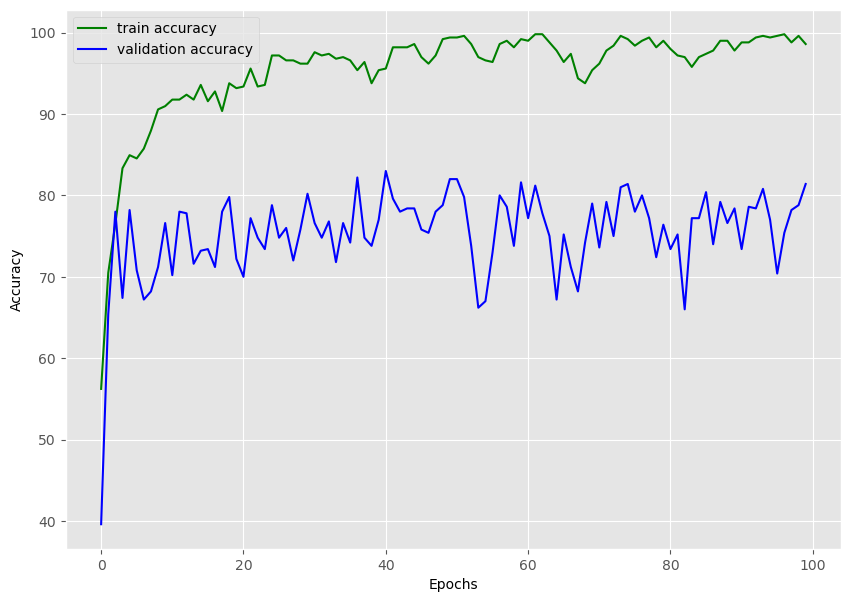

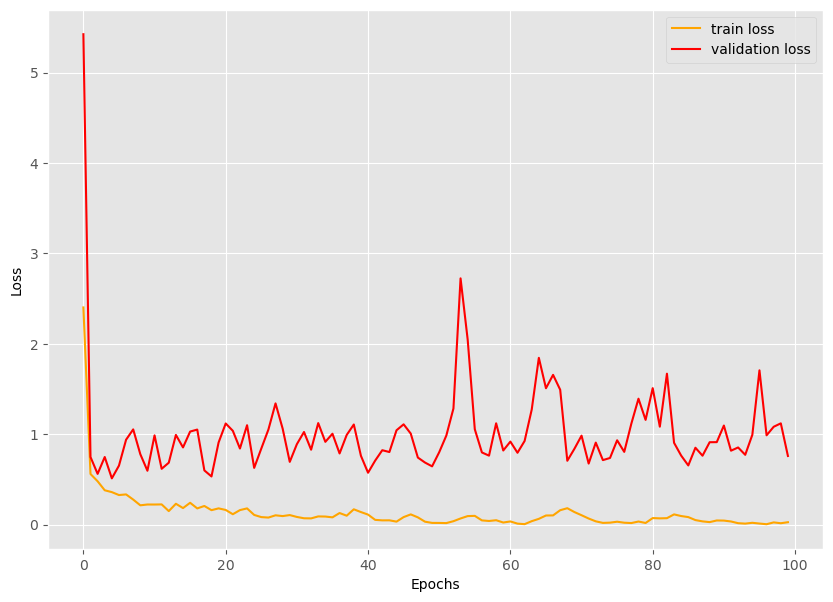

Saving model...
TRAINING COMPLETE


In [53]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"../chap08/img/{acc_plot_name}.png")
plt.show()

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f"../chap08/img/{loss_plot_name}.png")
plt.show()
    
print('Saving model...')
torch.save(model.state_dict(), f"../chap08/img/{model_name}.pth")
print('TRAINING COMPLETE')